In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import joblib
from dotenv import load_dotenv
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import os
from sqlalchemy import create_engine
import pymysql

Importing plotly failed. Interactive plots will not work.


### Conexão com Banco

In [2]:
# 🔹 Carregar variáveis do .env
load_dotenv()

True

In [3]:
# 🔹 Configuração do Banco de Dados MySQL 
DB_USERNAME = os.getenv("DB_USERNAME")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DB_HOST = os.getenv("DB_HOST")
TABLE_NAME = os.getenv("TABLE_NAME")

In [4]:
# 🔹 Criar a conexão com MySQL usando SQLAlchemy
engine = create_engine(f"mysql+pymysql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}")

In [5]:
# 🔹 Definir a query SQL para buscar os dados
query = f"SELECT * FROM medicao_producao"

In [6]:
# 🔹 Ler os dados diretamente do banco para um DataFrame Pandas
df = pd.read_sql(query, con=engine)

In [7]:
df.head()

,id,tempo,energia_solar_kw,clima,feed_in_kw,compra_kw
0,1,2025-02-15 01:05:06,NaN,Chuva pesada,None,None
1,2,2025-02-15 04:05:06,NaN,Ensolarado,None,None
2,3,2025-02-15 06:25:00,0.0,None,None,None
3,4,2025-02-15 06:30:00,0.0,None,None,None
4,5,2025-02-15 06:35:00,0.0,None,None,None


In [8]:
# Preparando dados para Prophet
df = df.reset_index()[["tempo", "energia_solar_kw"]]
df.columns = ["ds", "y"]

In [9]:
df.tail()

,ds,y
2112,2025-02-28 18:10:00,0.02
2113,2025-02-28 18:15:00,0.01
2114,2025-02-28 18:20:00,0.00
2115,2025-02-28 19:05:06,NaN
2116,2025-02-28 22:05:06,NaN


### Tratamento da base de dados

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2117 non-null   datetime64[ns]
 1   y       2005 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.2 KB


In [11]:
df[df["y"].isnull()] 

,ds,y
0,2025-02-15 01:05:06,NaN
1,2025-02-15 04:05:06,NaN
11,2025-02-15 07:05:06,NaN
48,2025-02-15 10:05:06,NaN
85,2025-02-15 13:05:06,NaN
...,...,...
2013,2025-02-28 10:05:06,NaN
2050,2025-02-28 13:05:06,NaN
2087,2025-02-28 16:05:06,NaN
2115,2025-02-28 19:05:06,NaN


In [12]:
df = df.dropna()

In [13]:
df.shape

(2005, 2)

### Treinando modelo

In [14]:
# 🔹 Criar o modelo Prophet e treinar
modelo = Prophet()
modelo.fit(df)

17:05:38 - cmdstanpy - INFO - Chain [1] start processing
17:05:39 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# 🔹 Fazer previsão para os próximos 30 dias
futuro = modelo.make_future_dataframe(periods=1440, freq="15T")
previsao = modelo.predict(futuro)

C:\Users\thzli\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


### Métricas de Avaliação

In [16]:
# 🔹 Juntar dados reais com as previsões
df_comparacao = df.merge(previsao[["ds", "yhat"]], on="ds", how="inner")

In [17]:
# 🔹 Calcular métricas de erro
mae = mean_absolute_error(df_comparacao["y"], df_comparacao["yhat"])
mse = mean_squared_error(df_comparacao["y"], df_comparacao["yhat"])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((df_comparacao["y"] - df_comparacao["yhat"]) / df_comparacao["y"])) * 100

In [18]:
# 🔹 Exibir resultados
print(f"\n🔹 Métricas de Avaliação do Modelo Prophet:")
print(f"📌 MAE  (Erro Absoluto Médio): {mae:.4f}")
print(f"📌 MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"📌 RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")


🔹 Métricas de Avaliação do Modelo Prophet:
📌 MAE  (Erro Absoluto Médio): 0.3657
📌 MSE  (Erro Quadrático Médio): 0.2532
📌 RMSE (Raiz do Erro Quadrático Médio): 0.5032


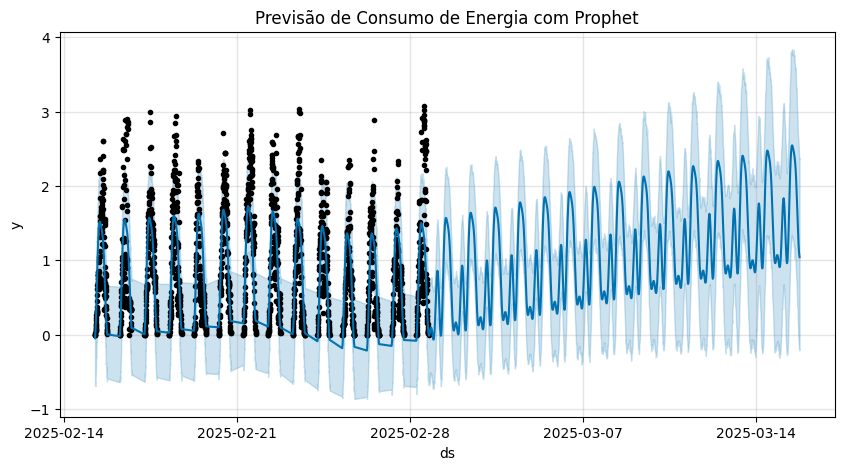

In [19]:
# 🔹 Plotar a previsão
fig, ax = plt.subplots(figsize=(10, 5))
modelo.plot(previsao, ax=ax)
plt.title("Previsão de Consumo de Energia com Prophet")
plt.show()

In [20]:
previsao.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3440,2025-03-15 17:20:00,1.610079,-0.075184,2.583818,0.489801,2.799184,-0.385938,-0.385938,-0.385938,-0.385938,-0.385938,-0.385938,0.0,0.0,0.0,1.224141
3441,2025-03-15 17:35:00,1.610804,-0.157573,2.487154,0.489216,2.801118,-0.452657,-0.452657,-0.452657,-0.452657,-0.452657,-0.452657,0.0,0.0,0.0,1.158147
3442,2025-03-15 17:50:00,1.611529,-0.207595,2.439397,0.488631,2.803051,-0.505762,-0.505762,-0.505762,-0.505762,-0.505762,-0.505762,0.0,0.0,0.0,1.105767
3443,2025-03-15 18:05:00,1.612254,-0.185653,2.366652,0.488046,2.804985,-0.544637,-0.544637,-0.544637,-0.544637,-0.544637,-0.544637,0.0,0.0,0.0,1.067617
3444,2025-03-15 18:20:00,1.612980,-0.204784,2.373719,0.487462,2.806919,-0.569444,-0.569444,-0.569444,-0.569444,-0.569444,-0.569444,0.0,0.0,0.0,1.043535


### Salvando em arquivo pkl

In [21]:
joblib.dump(modelo, "modelo_prophet.pkl")

['modelo_prophet.pkl']

### Salvando dados de previsão no Banco

In [22]:
previsao_data = previsao[['ds', 'yhat']]

In [23]:
previsao_data.rename(columns={"ds": "timestamp", "yhat": "geracao (kwh)"}, inplace=True)

C:\Users\thzli\AppData\Local\Temp\ipykernel_23372\2965436896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previsao_data.rename(columns={"ds": "timestamp", "yhat": "geracao (kwh)"}, inplace=True)


In [24]:
previsao_data

,timestamp,geracao (kwh)
0,2025-02-15 06:25:00,-0.046330
1,2025-02-15 06:30:00,-0.037022
2,2025-02-15 06:35:00,-0.024847
3,2025-02-15 06:40:00,-0.009843
4,2025-02-15 06:45:00,0.007935
...,...,...
3440,2025-03-15 17:20:00,1.224141
3441,2025-03-15 17:35:00,1.158147
3442,2025-03-15 17:50:00,1.105767
3443,2025-03-15 18:05:00,1.067617


In [25]:
# 🔹 Criar conexão com o MySQL
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USERNAME,
    password=DB_PASSWORD,
    database=DB_NAME,
)
cursor = conn.cursor()

In [26]:
query = f"""
INSERT INTO previsao_producao (`geracao (kwh)`, `timestamp`)
VALUES (%s, %s)
"""

In [27]:
# 🔹 Inserir previsões no banco usando apenas `ds` e `yhat`, renomeados na query
for _, row in previsao_data.iterrows():
    cursor.execute(query, (row["geracao (kwh)"], row["timestamp"]))

# 🔹 Confirmar e fechar conexão
conn.commit()
cursor.close()
conn.close()

In [29]:
# 🔹 Criar conexão com MySQL
conn = pymysql.connect(
    host=DB_HOST,
    user=DB_USERNAME,
    password=DB_PASSWORD,
    database=DB_NAME
)
cursor = conn.cursor()

# 🔹 Query SQL para buscar as últimas 10 linhas inseridas
query = f"""
SELECT * FROM previsao_producao
ORDER BY timestamp DESC
LIMIT 10;
"""

# 🔹 Executar a consulta
cursor.execute(query)

# 🔹 Obter os resultados e armazenar em um DataFrame Pandas
colunas = [desc[0] for desc in cursor.description]  # Captura os nomes das colunas
resultados = cursor.fetchall()
df = pd.DataFrame(resultados, columns=colunas)  # Criar DataFrame com os resultados

# 🔹 Fechar conexão
cursor.close()
conn.close()

# 🔹 Mostrar os dados no terminal
print("\n🔹 Últimas 10 Previsões Inseridas no Banco:")
print(df)


🔹 Últimas 10 Previsões Inseridas no Banco:
     id  geracao (kwh)           timestamp
0  4714        1.04354 2025-03-15 18:20:00
1  4713        1.06762 2025-03-15 18:05:00
2  4712        1.10577 2025-03-15 17:50:00
3  4711        1.15815 2025-03-15 17:35:00
4  4710        1.22414 2025-03-15 17:20:00
5  4709        1.30240 2025-03-15 17:05:00
6  4708        1.39092 2025-03-15 16:50:00
7  4707        1.48722 2025-03-15 16:35:00
8  4706        1.58845 2025-03-15 16:20:00
9  4705        1.69163 2025-03-15 16:05:00
